In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import re

from sklearn.learning_curve import validation_curve
from sklearn.model_selection  import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc

/home/fschmidt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/fschmidt/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
df1 = pd.DataFrame(pd.read_csv('train.csv'))
df2 = pd.DataFrame(pd.read_csv('test.csv'))

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df1['Sex'] = df1['Sex'].map({'female': 1, 'male': 0})
df1['Embarked'] = df1['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df1["Age"] = imp.fit_transform(df1[["Age"]]).ravel()
df1['Embarked'] = imp.fit_transform(df1[['Embarked']]).ravel()
df1.Embarked = df1.Embarked.astype(int)
df1.Age = df1.Age.astype(int)
df1['FamilySize'] = df1['SibSp'] + df1['Parch'] + 1
df1 = df1.assign(FamilySize = pd.Series(df1['FamilySize']))
df1['HasCabin'] = df1['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df1['Name_length'] = df1['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df1['Single'] = df1['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df1['SmallF'] = df1['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df1['MedF'] = df1['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df1['LargeF'] = df1['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df1['Title'] = df1['Name'].apply(get_title)
df1['Title'] = df1['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df1['Title'] = df1['Title'].replace('Mlle', 'Miss')
df1['Title'] = df1['Title'].replace('Ms', 'Miss')
df1['Title'] = df1['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df1['Title'] = df1['Title'].map(title_mapping)
df1['Title'] = df1['Title'].fillna(0)

#df1["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df1['Cabin'] ]) #zmapowac na inty
#df1['Cabin'] = df1['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df1 = df1.drop(columns = ['PassengerId', 'Cabin','Name', 'Ticket', 'Fare', 'Name_length'])
    
#============================================================================
    
df2['Sex'] = df2['Sex'].map({'female': 1, 'male': 0})
df2['Embarked'] = df2['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df2["Age"] = imp.fit_transform(df2[["Age"]]).ravel()
df2['Embarked'] = imp.fit_transform(df2[['Embarked']]).ravel()
df2.Embarked = df2.Embarked.astype(int)
df2.Age = df2.Age.astype(int)
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2 = df2.assign(FamilySize = pd.Series(df2['FamilySize']))    
df2['HasCabin'] = df2['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df2['Name_length'] = df2['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df2['Single'] = df2['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df2['SmallF'] = df2['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df2['MedF'] = df2['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df2['LargeF'] = df2['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df2['Title'] = df2['Name'].apply(get_title)
df2['Title'] = df2['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df2['Title'] = df2['Title'].replace('Mlle', 'Miss')
df2['Title'] = df2['Title'].replace('Ms', 'Miss')
df2['Title'] = df2['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df2['Title'] = df2['Title'].map(title_mapping)
df2['Title'] = df2['Title'].fillna(0)

#df2["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df2['Cabin'] ]) #zmapowac na inty
#df2['Cabin'] = df2['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df2 = df2.drop(columns = ['Name', 'Cabin', 'Ticket', 'Fare', 'Name_length'])

#print(df1)
#print(df2)

In [3]:
X = df1.drop(columns = ['Survived'])
y = df1['Survived']

skf = StratifiedKFold(n_splits = 4) #pobawic sie z iloscia splitow
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [4]:
d_train = lgb.Dataset(X_train, label = y_train)

params = {}
params['learning_rate'] = 0.099
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc' #'binary_logloss'
params['sub_feature'] = 0.72
params['num_leaves'] = 25 #2^(n-1)
params['min_data'] = 50
params['max_depth'] = 10 #n
params['lambda_l1'] = 0.5
params['feature_fraction'] = 0.3

clf = lgb.train(params, d_train, 100)
y_predict = clf.predict(X_test)

# for i in range(222):
#     if y_predict[i] >= 0.48:
#         y_predict[i] = 1
#     else:  
#         y_predict[i] = 0
        
# accuracy = accuracy_score(y_test, y_predict) 
# print(accuracy)

In [5]:
#df2 = sc.transform(df2)
#y2_pred = clf.predict(df2)
#print(df2)

Xt = df2.drop(columns = ['PassengerId'])
yt = df2['PassengerId']

yt = yt.reset_index(drop=True)
yt = pd.DataFrame(np.array(yt).reshape(len(yt)), columns = ['PassengerId'])
#print(yt)

ytt = yt

yt2_predict = clf.predict(sc.transform(Xt))

lgbm_pdict = pd.DataFrame({'lgbm': yt2_predict})

# print(yt2_predict)
# print(min(yt2_predict))
# print(max(yt2_predict))

# for i in range(418):
#     if yt2_predict[i] >= 0.48:
#        yt2_predict[i] = 1
#     else:  
#        yt2_predict[i] = 0

# print(yt2_predict)    
  
df2t = pd.DataFrame(yt2_predict, columns = ['Survived'])
#print(df2t)

yt['Survived'] = df2t['Survived']
# yt.Survived = yt.Survived.astype(int)
# print(yt)

lgbm_pdict.to_csv('pdb-lgbm.csv', index = False)

yt.to_csv('wynik-lgbm.csv', index = False)

In [6]:
yt.Survived.value_counts()

0.071757    26
0.106820    12
0.600680    10
0.194998     7
0.108922     7
0.088300     6
0.233648     5
0.154476     4
0.169171     4
0.162405     3
0.280623     3
0.476872     3
0.680968     3
0.090017     3
0.100303     3
0.148086     3
0.157700     3
0.578382     3
0.167305     3
0.126062     3
0.383853     3
0.164844     2
0.965862     2
0.339424     2
0.055291     2
0.521151     2
0.107603     2
0.097210     2
0.766392     2
0.825738     2
            ..
0.598874     1
0.950341     1
0.179894     1
0.794515     1
0.721760     1
0.148544     1
0.156463     1
0.498081     1
0.543109     1
0.490952     1
0.073333     1
0.677461     1
0.717811     1
0.109207     1
0.064533     1
0.245481     1
0.066464     1
0.160870     1
0.262720     1
0.758301     1
0.939651     1
0.810061     1
0.797675     1
0.442480     1
0.746009     1
0.936006     1
0.627496     1
0.099378     1
0.600762     1
0.583025     1
Name: Survived, Length: 276, dtype: int64

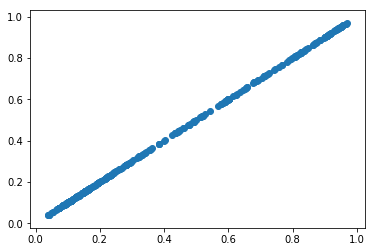

In [7]:
pt = df2['PassengerId']

#pt = pt.reset_index(drop=True)
#pt = pd.DataFrame(np.array(pt).reshape(len(pt)), columns = ['PassengerId'])

plt.scatter(yt2_predict,yt2_predict)


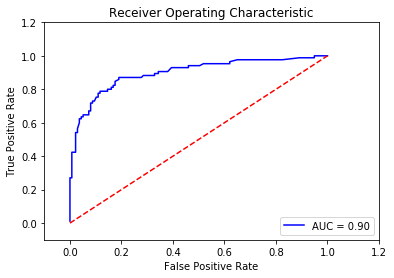

In [8]:
# Xplt = yt2_predict # false_positive_rate
# yplt = Xt # true_positive_rate 

# # This is the ROC curve
# plt.plot(Xplt,yplt)
# plt.show() 

# # This is the AUC
# auc = np.trapz(yplt,Xplt)

actual = y_test #df1['Survived']
predictions = y_predict #df2t

#print(actual)
#print(predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()